In [ ]:
!pip install pytorch_msssim

📂 Please upload a cover image (cover.jpg) and a watermark image (watermark.png)


Saving cover.jpg to cover.jpg
Saving watermark.png to watermark.png
Epoch [100/800]  Loss: 0.6482  Cover:0.0585  WM:0.0635
Epoch [200/800]  Loss: 0.4460  Cover:0.0380  WM:0.0661
Epoch [300/800]  Loss: 0.3522  Cover:0.0301  WM:0.0511
Epoch [400/800]  Loss: 0.3221  Cover:0.0280  WM:0.0417
Epoch [500/800]  Loss: 0.2878  Cover:0.0253  WM:0.0345
Epoch [600/800]  Loss: 0.2565  Cover:0.0230  WM:0.0263
Epoch [700/800]  Loss: 0.2423  Cover:0.0215  WM:0.0269
Epoch [800/800]  Loss: 0.2225  Cover:0.0199  WM:0.0231
PSNR(cover vs watermarked): 30.74 dB  (higher = more invisible)


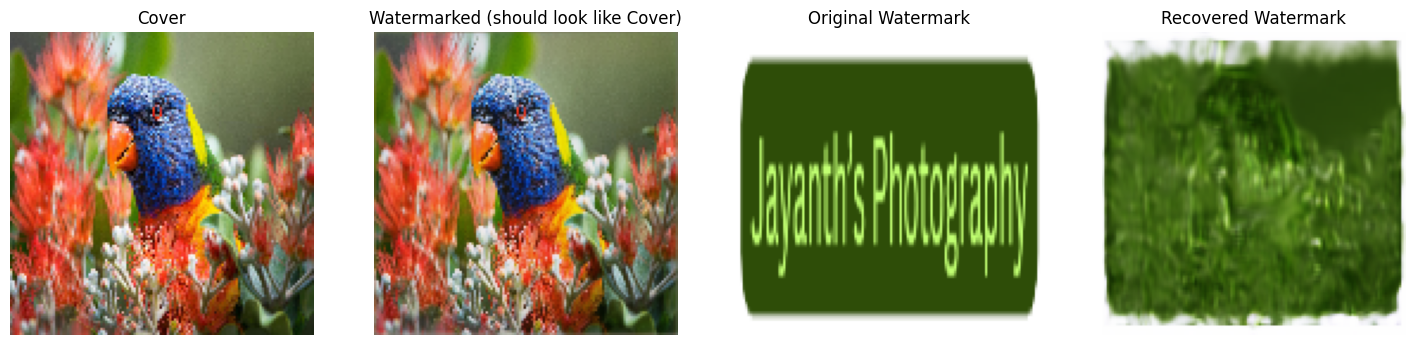

Saved: watermarked.png, recovered.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Invisible Watermarking — SSIM-based Invisibility + Dropout
# Colab instructions:
# 1) Runtime > Change runtime type > GPU (recommended)
# 2) Run this cell, upload cover.jpg and watermark.png when asked

import torch, torch.nn as nn, torch.optim as optim
import numpy as np, cv2, matplotlib.pyplot as plt
from google.colab import files
from pytorch_msssim import SSIM  # 👈 new for perceptual similarity

# -------------------------
# Upload your images
# -------------------------
print("📂 Please upload a cover image (cover.jpg) and a watermark image (watermark.png)")
uploaded = files.upload()

# Read & preprocess to 128x128 RGB in [0,1]
def load_img(path, size=128):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return img

cover_img = load_img("cover.jpg", 128)
watermark_img = load_img("watermark.png", 128)

# To tensors: (N,C,H,W)
cover = torch.tensor(cover_img).permute(2,0,1).unsqueeze(0)
watermark = torch.tensor(watermark_img).permute(2,0,1).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cover, watermark = cover.to(device), watermark.to(device)

# -------------------------
# Models: hider (Hider) & extracter (Revealer)
# -------------------------
class Hider(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Dropout(0.2),  # 👈 added dropout
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()   # output: watermarked image ~ cover
        )
    def forward(self, cover, wm):
        x = torch.cat([cover, wm], dim=1)
        return self.net(x)

class Extracter(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid()   # output: recovered watermark
        )
    def forward(self, watermarked_img):
        return self.net(watermarked_img)

hider, extracter = Hider().to(device), Extracter().to(device)

# -------------------------
# Losses & Optimizer
# -------------------------
mse = nn.MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3)

# Balance: invisibility vs recovery quality
LAMBDA_COVER = 10.0   # 👈 cover similarity more important
LAMBDA_WM    = 1.0    # 👈 watermark recovery still important

opt = optim.Adam(list(hider.parameters()) + list(extracter.parameters()), lr=1e-3)

# -------------------------
# Training
# -------------------------
EPOCHS = 800
NOISE_STD = 0.0   # noise disabled for invisibility focus

for epoch in range(1, EPOCHS+1):
    hider.train(); extracter.train()

    # 1) Hide
    watermarked = hider(cover, watermark)

    # small noise (disabled here)
    noisy = watermarked + NOISE_STD * torch.randn_like(watermarked)
    noisy = torch.clamp(noisy, 0.0, 1.0)

    # 2) Reveal
    recovered = extracter(noisy)

    # 3) Losses
    loss_cover = 1 - ssim_loss(watermarked, cover)   # 👈 SSIM-based invisibility
    loss_wm = mse(recovered, watermark)              # pixel-wise recovery
    loss = LAMBDA_COVER * loss_cover + LAMBDA_WM * loss_wm

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch:>3}/{EPOCHS}]  "
              f"Loss: {loss.item():.4f}  Cover:{loss_cover.item():.4f}  WM:{loss_wm.item():.4f}")

# -------------------------
# Evaluate & Visualize
# -------------------------
hider.eval(); extracter.eval()
with torch.no_grad():
    watermarked = hider(cover, watermark)
    recovered = extracter(watermarked)

def to_np_img(t):  # (1,C,H,W)->(H,W,C) uint8
    arr = np.transpose(t[0].detach().cpu().numpy(), (1,2,0))
    arr = (arr * 255.0).clip(0,255).astype(np.uint8)
    return arr

cover_np       = to_np_img(cover)
watermark_np   = to_np_img(watermark)
watermarked_np = to_np_img(watermarked)
recovered_np   = to_np_img(recovered)

# PSNR utility
def psnr(a, b, max_val=255.0):
    mse_val = np.mean((a.astype(np.float32) - b.astype(np.float32))**2)
    if mse_val == 0: return 99.0
    return 20 * np.log10(max_val) - 10 * np.log10(mse_val)

print(f"PSNR(cover vs watermarked): {psnr(cover_np, watermarked_np):.2f} dB  (higher = more invisible)")

# Show results
fig, axs = plt.subplots(1,4, figsize=(18,4))
axs[0].imshow(cover_np);       axs[0].set_title("Cover")
axs[1].imshow(watermarked_np); axs[1].set_title("Watermarked (should look like Cover)")
axs[2].imshow(watermark_np);   axs[2].set_title("Original Watermark")
axs[3].imshow(recovered_np);   axs[3].set_title("Recovered Watermark")
for a in axs: a.axis('off')
plt.show()

# -------------------------
# Save & download outputs
# -------------------------
cv2.imwrite("watermarked.png", cv2.cvtColor(watermarked_np, cv2.COLOR_RGB2BGR))
cv2.imwrite("recovered.png",   cv2.cvtColor(recovered_np,   cv2.COLOR_RGB2BGR))
print("Saved: watermarked.png, recovered.png")
files.download("watermarked.png")
files.download("recovered.png")


📂 Please upload a cover image (cover1.jpg) and a watermark image (watermark1.png)


Saving cover1.jpg to cover1 (1).jpg
Saving watermark1.png to watermark1 (1).png
Epoch [100/800]  Loss: 0.4213  Cover:0.0348  WM:0.0729
Epoch [200/800]  Loss: 0.3307  Cover:0.0263  WM:0.0678
Epoch [300/800]  Loss: 0.2644  Cover:0.0202  WM:0.0627
Epoch [400/800]  Loss: 0.2388  Cover:0.0180  WM:0.0585
Epoch [500/800]  Loss: 0.2080  Cover:0.0157  WM:0.0514
Epoch [600/800]  Loss: 0.1792  Cover:0.0137  WM:0.0424
Epoch [700/800]  Loss: 0.1707  Cover:0.0127  WM:0.0435
Epoch [800/800]  Loss: 0.1469  Cover:0.0116  WM:0.0314
PSNR(cover vs watermarked): 34.40 dB  (higher = more invisible)


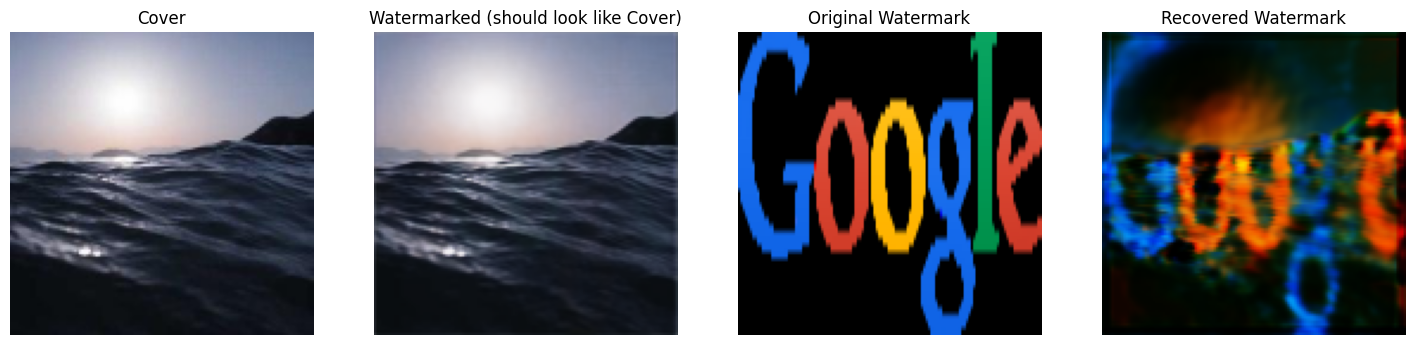

Saved: watermarked.png, recovered.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Invisible Watermarking — SSIM-based Invisibility + Dropout
# Colab instructions:
# 1) Runtime > Change runtime type > GPU (recommended)
# 2) Run this cell, upload cover.jpg and watermark.png when asked

import torch, torch.nn as nn, torch.optim as optim
import numpy as np, cv2, matplotlib.pyplot as plt
from google.colab import files
from pytorch_msssim import SSIM  # 👈 new for perceptual similarity

# -------------------------
# Upload your images
# -------------------------
print("📂 Please upload a cover image (cover1.jpg) and a watermark image (watermark1.png)")
uploaded = files.upload()

# Read & preprocess to 128x128 RGB in [0,1]
def load_img(path, size=128):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return img

cover_img = load_img("cover1.jpg", 128)
watermark_img = load_img("watermark1.png", 128)

# To tensors: (N,C,H,W)
cover = torch.tensor(cover_img).permute(2,0,1).unsqueeze(0)
watermark = torch.tensor(watermark_img).permute(2,0,1).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cover, watermark = cover.to(device), watermark.to(device)

# -------------------------
# Models: hider (Hider) & extracter (Revealer)
# -------------------------
class Hider(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Dropout(0.2),  # 👈 added dropout
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()   # output: watermarked image ~ cover
        )
    def forward(self, cover, wm):
        x = torch.cat([cover, wm], dim=1)
        return self.net(x)

class Extracter(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid()   # output: recovered watermark
        )
    def forward(self, watermarked_img):
        return self.net(watermarked_img)

hider, extracter = hider().to(device), extracter().to(device)

# -------------------------
# Losses & Optimizer
# -------------------------
mse = nn.MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3)

# Balance: invisibility vs recovery quality
LAMBDA_COVER = 10.0   # 👈 cover similarity more important
LAMBDA_WM    = 1.0    # 👈 watermark recovery still important

opt = optim.Adam(list(hider.parameters()) + list(extracter.parameters()), lr=1e-3)

# -------------------------
# Training
# -------------------------
EPOCHS = 800
NOISE_STD = 0.0   # noise disabled for invisibility focus

for epoch in range(1, EPOCHS+1):
    hider.train(); extracter.train()

    # 1) Hide
    watermarked = hider(cover, watermark)

    # small noise (disabled here)
    noisy = watermarked + NOISE_STD * torch.randn_like(watermarked)
    noisy = torch.clamp(noisy, 0.0, 1.0)

    # 2) Reveal
    recovered = extracter(noisy)

    # 3) Losses
    loss_cover = 1 - ssim_loss(watermarked, cover)   # 👈 SSIM-based invisibility
    loss_wm = mse(recovered, watermark)              # pixel-wise recovery
    loss = LAMBDA_COVER * loss_cover + LAMBDA_WM * loss_wm

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch:>3}/{EPOCHS}]  "
              f"Loss: {loss.item():.4f}  Cover:{loss_cover.item():.4f}  WM:{loss_wm.item():.4f}")

# -------------------------
# Evaluate & Visualize
# -------------------------
hider.eval(); extracter.eval()
with torch.no_grad():
    watermarked = hider(cover, watermark)
    recovered = extracter(watermarked)

def to_np_img(t):  # (1,C,H,W)->(H,W,C) uint8
    arr = np.transpose(t[0].detach().cpu().numpy(), (1,2,0))
    arr = (arr * 255.0).clip(0,255).astype(np.uint8)
    return arr

cover_np       = to_np_img(cover)
watermark_np   = to_np_img(watermark)
watermarked_np = to_np_img(watermarked)
recovered_np   = to_np_img(recovered)

# PSNR utility
def psnr(a, b, max_val=255.0):
    mse_val = np.mean((a.astype(np.float32) - b.astype(np.float32))**2)
    if mse_val == 0: return 99.0
    return 20 * np.log10(max_val) - 10 * np.log10(mse_val)

print(f"PSNR(cover vs watermarked): {psnr(cover_np, watermarked_np):.2f} dB  (higher = more invisible)")

# Show results
fig, axs = plt.subplots(1,4, figsize=(18,4))
axs[0].imshow(cover_np);       axs[0].set_title("Cover")
axs[1].imshow(watermarked_np); axs[1].set_title("Watermarked (should look like Cover)")
axs[2].imshow(watermark_np);   axs[2].set_title("Original Watermark")
axs[3].imshow(recovered_np);   axs[3].set_title("Recovered Watermark")
for a in axs: a.axis('off')
plt.show()

# -------------------------
# Save & download outputs
# -------------------------
cv2.imwrite("watermarked.png", cv2.cvtColor(watermarked_np, cv2.COLOR_RGB2BGR))
cv2.imwrite("recovered.png",   cv2.cvtColor(recovered_np,   cv2.COLOR_RGB2BGR))
print("Saved: watermarked.png, recovered.png")
files.download("watermarked.png")
files.download("recovered.png")


📂 Please upload a cover image (cover1.jpg) and a watermark image (watermark1.png)


Saving cover1.jpg to cover1 (1).jpg
Saving watermark1.jpg to watermark1 (1).jpg
Epoch [100/800]  Loss: 0.5904  Cover:0.0552  WM:0.0379
Epoch [200/800]  Loss: 0.4836  Cover:0.0453  WM:0.0307
Epoch [300/800]  Loss: 0.3882  Cover:0.0363  WM:0.0250
Epoch [400/800]  Loss: 0.3418  Cover:0.0321  WM:0.0212
Epoch [500/800]  Loss: 0.3107  Cover:0.0291  WM:0.0198
Epoch [600/800]  Loss: 0.2702  Cover:0.0251  WM:0.0193
Epoch [700/800]  Loss: 0.2402  Cover:0.0224  WM:0.0164
Epoch [800/800]  Loss: 0.2242  Cover:0.0209  WM:0.0153
PSNR(cover vs watermarked): 28.82 dB  (higher = more invisible)


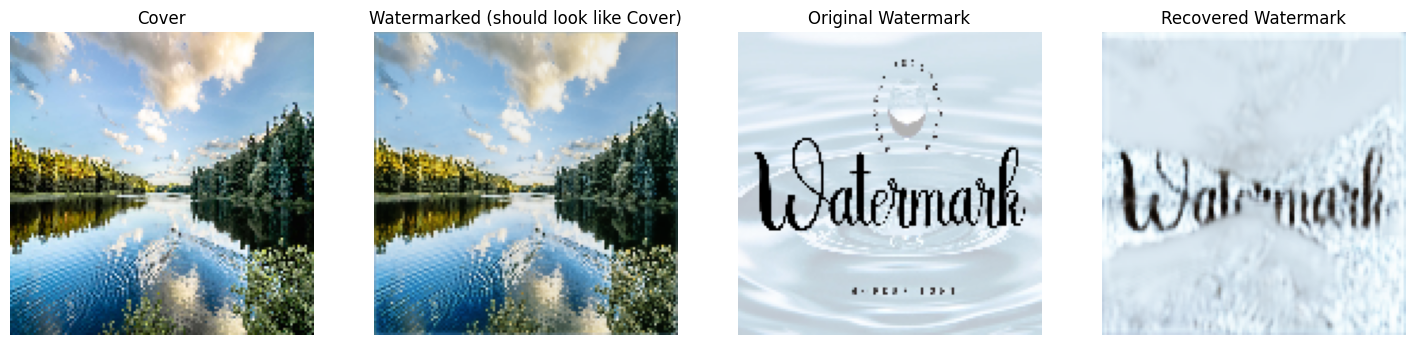

Saved: watermarked.png, recovered.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Invisible Watermarking — SSIM-based Invisibility + Dropout
# Colab instructions:
# 1) Runtime > Change runtime type > GPU (recommended)
# 2) Run this cell, upload cover.jpg and watermark.png when asked

import torch, torch.nn as nn, torch.optim as optim
import numpy as np, cv2, matplotlib.pyplot as plt
from google.colab import files
from pytorch_msssim import SSIM  # 👈 new for perceptual similarity

# -------------------------
# Upload your images
# -------------------------
print("📂 Please upload a cover image (cover1.jpg) and a watermark image (watermark1.png)")
uploaded = files.upload()

# Read & preprocess to 128x128 RGB in [0,1]
def load_img(path, size=128):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return img

cover_img = load_img("cover1.jpg", 128)
watermark_img = load_img("watermark1.jpg", 128)

# To tensors: (N,C,H,W)
cover = torch.tensor(cover_img).permute(2,0,1).unsqueeze(0)
watermark = torch.tensor(watermark_img).permute(2,0,1).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cover, watermark = cover.to(device), watermark.to(device)

# -------------------------
# Models: hider (Hider) & extracter (Revealer)
# -------------------------
class Hider(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Dropout(0.2),  # 👈 added dropout
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()   # output: watermarked image ~ cover
        )
    def forward(self, cover, wm):
        x = torch.cat([cover, wm], dim=1)
        return self.net(x)

class Extracter(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid()   # output: recovered watermark
        )
    def forward(self, watermarked_img):
        return self.net(watermarked_img)

hider, extracter = hider().to(device), extracter().to(device)

# -------------------------
# Losses & Optimizer
# -------------------------
mse = nn.MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3)

# Balance: invisibility vs recovery quality
LAMBDA_COVER = 10.0   # 👈 cover similarity more important
LAMBDA_WM    = 1.0    # 👈 watermark recovery still important

opt = optim.Adam(list(hider.parameters()) + list(extracter.parameters()), lr=1e-3)

# -------------------------
# Training
# -------------------------
EPOCHS = 800
NOISE_STD = 0.0   # noise disabled for invisibility focus

for epoch in range(1, EPOCHS+1):
    hider.train(); extracter.train()

    # 1) Hide
    watermarked = hider(cover, watermark)

    # small noise (disabled here)
    noisy = watermarked + NOISE_STD * torch.randn_like(watermarked)
    noisy = torch.clamp(noisy, 0.0, 1.0)

    # 2) Reveal
    recovered = extracter(noisy)

    # 3) Losses
    loss_cover = 1 - ssim_loss(watermarked, cover)   # 👈 SSIM-based invisibility
    loss_wm = mse(recovered, watermark)              # pixel-wise recovery
    loss = LAMBDA_COVER * loss_cover + LAMBDA_WM * loss_wm

    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch:>3}/{EPOCHS}]  "
              f"Loss: {loss.item():.4f}  Cover:{loss_cover.item():.4f}  WM:{loss_wm.item():.4f}")

# -------------------------
# Evaluate & Visualize
# -------------------------
hider.eval(); extracter.eval()
with torch.no_grad():
    watermarked = hider(cover, watermark)
    recovered = extracter(watermarked)

def to_np_img(t):  # (1,C,H,W)->(H,W,C) uint8
    arr = np.transpose(t[0].detach().cpu().numpy(), (1,2,0))
    arr = (arr * 255.0).clip(0,255).astype(np.uint8)
    return arr

cover_np       = to_np_img(cover)
watermark_np   = to_np_img(watermark)
watermarked_np = to_np_img(watermarked)
recovered_np   = to_np_img(recovered)

# PSNR utility
def psnr(a, b, max_val=255.0):
    mse_val = np.mean((a.astype(np.float32) - b.astype(np.float32))**2)
    if mse_val == 0: return 99.0
    return 20 * np.log10(max_val) - 10 * np.log10(mse_val)

print(f"PSNR(cover vs watermarked): {psnr(cover_np, watermarked_np):.2f} dB  (higher = more invisible)")

# Show results
fig, axs = plt.subplots(1,4, figsize=(18,4))
axs[0].imshow(cover_np);       axs[0].set_title("Cover")
axs[1].imshow(watermarked_np); axs[1].set_title("Watermarked (should look like Cover)")
axs[2].imshow(watermark_np);   axs[2].set_title("Original Watermark")
axs[3].imshow(recovered_np);   axs[3].set_title("Recovered Watermark")
for a in axs: a.axis('off')
plt.show()

# -------------------------
# Save & download outputs
# -------------------------
cv2.imwrite("watermarked.png", cv2.cvtColor(watermarked_np, cv2.COLOR_RGB2BGR))
cv2.imwrite("recovered.png",   cv2.cvtColor(recovered_np,   cv2.COLOR_RGB2BGR))
print("Saved: watermarked.png, recovered.png")
files.download("watermarked.png")
files.download("recovered.png")


In [ ]:
# ✅ Invisible Watermarking — Multi-Pair Support + Any Image Format
# Colab setup:
# 1) Runtime > Change runtime type > GPU (recommended)
# 2) Run this cell and upload all your cover/watermark pairs
# Naming pattern: e.g., "sample1_cover.jpg" and "sample1_wm.png"

import torch, torch.nn as nn, torch.optim as optim
import numpy as np, cv2, matplotlib.pyplot as plt, os, re
from google.colab import files
from pytorch_msssim import SSIM

print("📂 Upload all cover/watermark pairs (e.g. sample1_cover.jpg, sample1_wm.png)")
uploaded = files.upload()

# --------------------------------------------------------
# Helper to load and preprocess images
# --------------------------------------------------------
def load_img(path, size=128):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"❌ Cannot read {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    return img

# --------------------------------------------------------
# Detect and pair cover/watermark images by base name
# --------------------------------------------------------
def find_pairs(uploaded_dict):
    files_list = list(uploaded_dict.keys())
    pairs = []
    pattern = re.compile(r'(.+?)_cover\.[^.]+$')

    for f in files_list:
        m = pattern.match(f)
        if m:
            base = m.group(1)
            # find corresponding watermark file
            wm_candidates = [w for w in files_list if re.match(fr'{re.escape(base)}_wm\.[^.]+$', w)]
            if wm_candidates:
                pairs.append((f, wm_candidates[0]))
    return pairs

pairs = find_pairs(uploaded)
if not pairs:
    raise ValueError("❌ No valid pairs found! Make sure files are named like 'name_cover.jpg' and 'name_wm.png'")
print(f"✅ Found {len(pairs)} pairs:", pairs)

# --------------------------------------------------------
# Model definitions (hider + extracter)
# --------------------------------------------------------
class Hider(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Dropout(0.2),
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1), nn.Sigmoid()
        )
    def forward(self, cover, wm):
        x = torch.cat([cover, wm], dim=1)
        return self.net(x)

class Extracter(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hider, extracter = hider().to(device), extracter().to(device)

# --------------------------------------------------------
# Losses & Optimizer
# --------------------------------------------------------
mse = nn.MSELoss()
ssim_loss = SSIM(data_range=1.0, size_average=True, channel=3)
LAMBDA_COVER, LAMBDA_WM = 10.0, 1.0
opt = optim.Adam(list(hider.parameters()) + list(extracter.parameters()), lr=1e-3)

# --------------------------------------------------------
# Training & Processing for each pair
# --------------------------------------------------------
def to_tensor(img):
    return torch.tensor(img).permute(2,0,1).unsqueeze(0).to(device)

def to_np(t):
    arr = np.transpose(t[0].detach().cpu().numpy(), (1,2,0))
    return (arr * 255.0).clip(0,255).astype(np.uint8)

def psnr(a,b,max_val=255.0):
    mse_val = np.mean((a.astype(np.float32)-b.astype(np.float32))**2)
    return 99.0 if mse_val==0 else 20*np.log10(max_val) - 10*np.log10(mse_val)

EPOCHS = 500

for cover_name, wm_name in pairs:
    print(f"\n🎯 Processing pair: {cover_name} & {wm_name}")
    cover_img = load_img(cover_name)
    watermark_img = load_img(wm_name)

    cover, watermark = to_tensor(cover_img), to_tensor(watermark_img)

    # (Optional) Reinitialize weights for fairness across pairs
    hider.apply(lambda m: isinstance(m, nn.Conv2d) and m.reset_parameters())
    extracter.apply(lambda m: isinstance(m, nn.Conv2d) and m.reset_parameters())

    for epoch in range(1, EPOCHS+1):
        hider.train(); extracter.train()

        watermarked = hider(cover, watermark)
        recovered = extracter(watermarked)

        loss_cover = 1 - ssim_loss(watermarked, cover)
        loss_wm = mse(recovered, watermark)
        loss = LAMBDA_COVER*loss_cover + LAMBDA_WM*loss_wm

        opt.zero_grad(); loss.backward(); opt.step()

        if epoch % 100 == 0:
            print(f"  Epoch {epoch}/{EPOCHS} | Loss {loss.item():.4f} | Cover {loss_cover.item():.4f} | WM {loss_wm.item():.4f}")

    hider.eval(); extracter.eval()
    with torch.no_grad():
        watermarked = hider(cover, watermark)
        recovered = extracter(watermarked)

    cover_np, watermarked_np, wm_np, rec_np = map(to_np, [cover, watermarked, watermark, recovered])
    print(f"PSNR(cover vs watermarked): {psnr(cover_np, watermarked_np):.2f} dB")

    # Save outputs
    base = re.match(r'(.+?)_cover\.[^.]+$', cover_name).group(1)
    watermarked_name = f"{base}_watermarked.png"
    recovered_name   = f"{base}_recovered.png"

    cv2.imwrite(watermarked_name, cv2.cvtColor(watermarked_np, cv2.COLOR_RGB2BGR))
    cv2.imwrite(recovered_name,   cv2.cvtColor(rec_np,        cv2.COLOR_RGB2BGR))
    print(f"✅ Saved: {watermarked_name}, {recovered_name}")

    files.download(watermarked_name)
    files.download(recovered_name)


📂 Upload all cover/watermark pairs (e.g. sample1_cover.jpg, sample1_wm.png)


Saving sample3_cover.jpg to sample3_cover.jpg
Saving sample3_wm.webp to sample3_wm.webp
Saving sample4_cover.jpg to sample4_cover.jpg
Saving sample4_wm.webp to sample4_wm.webp
✅ Found 2 pairs: [('sample3_cover.jpg', 'sample3_wm.webp'), ('sample4_cover.jpg', 'sample4_wm.webp')]

🎯 Processing pair: sample3_cover.jpg & sample3_wm.webp
  Epoch 100/500 | Loss 0.6238 | Cover 0.0532 | WM 0.0915
  Epoch 200/500 | Loss 0.4167 | Cover 0.0340 | WM 0.0770
  Epoch 300/500 | Loss 0.3311 | Cover 0.0270 | WM 0.0613
  Epoch 400/500 | Loss 0.2971 | Cover 0.0233 | WM 0.0640
  Epoch 500/500 | Loss 0.2790 | Cover 0.0224 | WM 0.0547
PSNR(cover vs watermarked): 32.05 dB
✅ Saved: sample3_watermarked.png, sample3_recovered.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 Processing pair: sample4_cover.jpg & sample4_wm.webp
  Epoch 100/500 | Loss 0.7708 | Cover 0.0629 | WM 0.1419
  Epoch 200/500 | Loss 0.4745 | Cover 0.0406 | WM 0.0681
  Epoch 300/500 | Loss 0.3583 | Cover 0.0310 | WM 0.0488
  Epoch 400/500 | Loss 0.2935 | Cover 0.0257 | WM 0.0362
  Epoch 500/500 | Loss 0.2666 | Cover 0.0235 | WM 0.0313
PSNR(cover vs watermarked): 29.52 dB
✅ Saved: sample4_watermarked.png, sample4_recovered.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>